#### Instalação dos módulos necessários

In [ ]:
%pip install duckdb
%pip install keras
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install pydot
%pip install scikit-learn
%pip install seaborn
%pip install warnings

#### Importação dos módulos necessários

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import duckdb as ddb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
from Custom import Custom_LSTM as CL

#### Ignora warnings que serão gerados

In [3]:
warnings.filterwarnings("ignore")

#### Leitura e análise do conjunto de treino das ações do Banco do Brasil (BBAS3)

In [4]:
raw_bbas3_train = pd.read_csv("_datasets/bbas3/treino.csv")
raw_bbas3_train.tail(5)

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
4730,4731,2019-03-19,39.001053,38.947137,1,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129,37.373718,38.333908,38.777073,38.570271,39.212849
4731,4732,2019-03-20,38.126942,38.865118,-1,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129,37.373718,38.333908,38.777073,38.570271
4732,4733,2019-03-21,37.326935,38.711299,-1,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129,37.373718,38.333908,38.777073
4733,4734,2019-03-22,35.297241,38.369894,-1,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129,37.373718,38.333908
4734,4735,2019-03-25,35.549099,38.087814,-1,35.297241,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129,37.373718


Perceba que, ao importar o conjunto de dados de treino, podemos realizar algumas alterações para facilitar a análise e manipulação das informações.

- Remoção de variáveis

    - "Unnamed: 0" : o registro representa um índice.
    - "Date" : o registro representa a data de coleta do dado.
    - "Smoothed_Close" : o registro representa o valor suavizado do fechamento do ativo - citado como "apenas uma curiosidade".

- Ordenação das variáveis

    - Para facilitar a interpretação, iremos ordenar o conjunto de dados de treino pelas variáveis independentes seguidas da variável dependente.

In [5]:
spec_bbas3_train = raw_bbas3_train.drop(columns="Smoothed_Close")
spec_bbas3_train = spec_bbas3_train[["Close", "Past_1_Days_Close", "Past_2_Days_Close", "Past_3_Days_Close", "Past_4_Days_Close", "Past_5_Days_Close", "Past_6_Days_Close", "Past_7_Days_Close", "Past_8_Days_Close", "Past_9_Days_Close", "Past_10_Days_Close", "Past_11_Days_Close", "Past_12_Days_Close", "Past_13_Days_Close", "Past_14_Days_Close", "Past_15_Days_Close", "Label"]]
spec_bbas3_train.tail(5)

,Close,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close,Label
4730,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129,37.373718,38.333908,38.777073,38.570271,39.212849,1
4731,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129,37.373718,38.333908,38.777073,38.570271,-1
4732,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129,37.373718,38.333908,38.777073,-1
4733,35.297241,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129,37.373718,38.333908,-1
4734,35.549099,35.297241,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129,37.373718,-1


Com o conjunto de dados de treino ordenado e livre de variáveis que não serão utilizadas, podemos realizar a análise inicial dos dados.

In [6]:
spec_bbas3_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4735 entries, 0 to 4734
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close               4735 non-null   float64
 1   Past_1_Days_Close   4735 non-null   float64
 2   Past_2_Days_Close   4735 non-null   float64
 3   Past_3_Days_Close   4735 non-null   float64
 4   Past_4_Days_Close   4735 non-null   float64
 5   Past_5_Days_Close   4735 non-null   float64
 6   Past_6_Days_Close   4735 non-null   float64
 7   Past_7_Days_Close   4735 non-null   float64
 8   Past_8_Days_Close   4735 non-null   float64
 9   Past_9_Days_Close   4735 non-null   float64
 10  Past_10_Days_Close  4735 non-null   float64
 11  Past_11_Days_Close  4735 non-null   float64
 12  Past_12_Days_Close  4735 non-null   float64
 13  Past_13_Days_Close  4735 non-null   float64
 14  Past_14_Days_Close  4735 non-null   float64
 15  Past_15_Days_Close  4735 non-null   float64
 16  Label 

Conforme apresentado acima, notamos que nenhuma das variáveis apresenta valores nulos, portanto, neste momento, não precisaremos remover ou realizar a inputação de valores como tratamento a valores ausentes.  

Dessa forma, como próximos passos, iremos analisar o comportamento das variáveis a fim de entender se o conjunto de dados de treino está balanceado (número de compras e vendas similar) e, em seguida, verificar a correlação entre as variáveis.

In [7]:
label_distribution = ddb.sql("""SELECT Label, COUNT(*) AS Regs from spec_bbas3_train GROUP BY 1""").to_df()
size = spec_bbas3_train.shape[0]
buy_count = label_distribution["Regs"][0]
sell_count = label_distribution["Regs"][1]
buy_percentual = round((buy_count / size) * 100, 2)
sell_percentual = round((sell_count / size) * 100, 2)

print(f"O conjunto de dados possui {size} registros, onde:")
print(f" -> Vendas: {buy_count} ou {buy_percentual}%")
print(f" -> Compras: {sell_count} ou {sell_percentual}%")

O conjunto de dados possui 4735 registros, onde:
 -> Vendas: 2602 ou 54.95%
 -> Compras: 2133 ou 45.05%


O conjunto de dados de treino apresenta uma boa distribuição entre as classes, sendo assim, não será necessário aplicar nenhuma técnica de amostragem para balancear os dados, o que geralmente é feito para evitar que o modelo tornesse especialista em uma única classe.

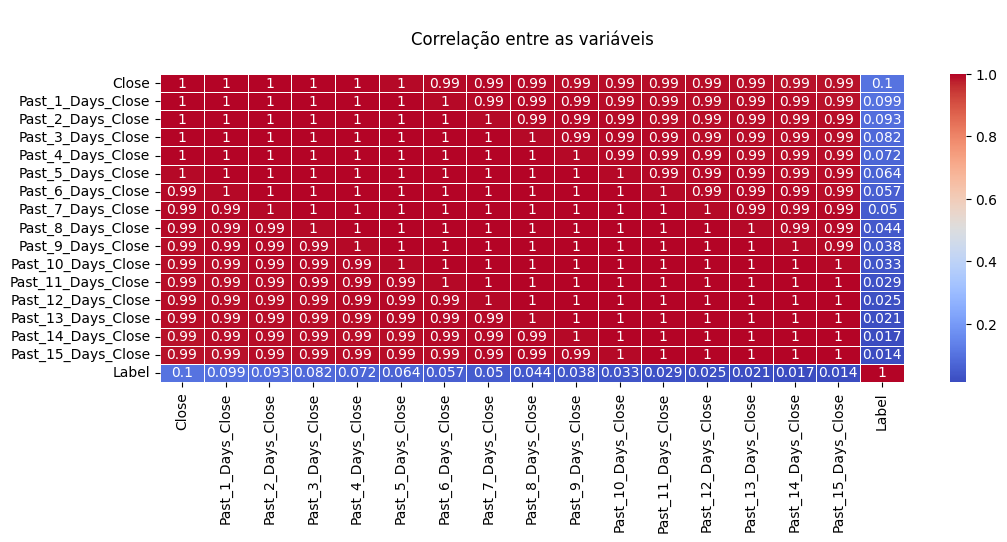

In [8]:
correlation = spec_bbas3_train.select_dtypes("number").corr()

plt.figure(figsize=(12, 4))

sns.heatmap(
    correlation, 
    annot=True, 
    annot_kws={"size" : 10},
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5,
    linecolor="white"
)

plt.title("\nCorrelação entre as variáveis\n", fontdict={"size" : 12})

plt.show()

Além disso, há outros dois comportamentos importantes a serem notados:

- Variável dependente: a correlação entre a ação de venda/compra diminui ao passar dos dias, ou seja, considerando APENAS o que é apresentado acima, poderíamos pressupor que a ação é tomada com base nos dados mais recentes, ou seja, uma janela mais curta de dias.

- Variáveis independentes: diferente da variável dependente, todas as variáveis independentes apresentam uma alta correlação entre sí, o que nos leva a pensar que o valor de fechamento em D-15 influencia em D-14 e assim sucessivamente.

Posto isso, iremos desenvolver um modelo baseline para fazer uma classificação inicial das ações.

#### Leitura e análise do conjunto de teste das ações do Banco do Brasil (BBAS3)

In [9]:
raw_bbas3_test = pd.read_csv("_datasets/bbas3/teste.csv")
raw_bbas3_test.tail(5)

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
1180,5916,2023-12-21,54.290001,53.331493,1,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685,53.829391,53.829391,54.038074,53.928764
1181,5917,2023-12-22,54.439999,53.442343,1,54.290001,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685,53.829391,53.829391,54.038074
1182,5918,2023-12-26,54.939999,53.592109,1,54.439999,54.290001,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685,53.829391,53.829391
1183,5919,2023-12-27,54.860001,53.718898,1,54.939999,54.439999,54.290001,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685,53.829391
1184,5920,2023-12-28,55.389999,53.886008,1,54.860001,54.939999,54.439999,54.290001,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685


Para mantermos o padrão, iremos realizar os mesmos tratamentos que foram realizados no conjunto de treino no conjunto de teste, ou seja, a remoção das colunas "Unamed: 0", "Date" e "Smoothed_Close" (que não serão utilizadas no treinamento dos modelos) e a ordenação das variáveis para facilitar a leitura.

In [10]:
spec_bbas3_test = raw_bbas3_test.drop(columns="Smoothed_Close")
spec_bbas3_test = spec_bbas3_test[["Close", "Past_1_Days_Close", "Past_2_Days_Close", "Past_3_Days_Close", "Past_4_Days_Close", "Past_5_Days_Close", "Past_6_Days_Close", "Past_7_Days_Close", "Past_8_Days_Close", "Past_9_Days_Close", "Past_10_Days_Close", "Past_11_Days_Close", "Past_12_Days_Close", "Past_13_Days_Close", "Past_14_Days_Close", "Past_15_Days_Close", "Label"]]
spec_bbas3_test.tail(5)

,Close,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close,Label
1180,54.290001,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685,53.829391,53.829391,54.038074,53.928764,1
1181,54.439999,54.290001,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685,53.829391,53.829391,54.038074,1
1182,54.939999,54.439999,54.290001,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685,53.829391,53.829391,1
1183,54.860001,54.939999,54.439999,54.290001,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685,53.829391,1
1184,55.389999,54.860001,54.939999,54.439999,54.290001,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685,1


Com o tratamento realizado, analisaremos se de fato não existem informações nulas no conjunto de dados de treino.

In [11]:
spec_bbas3_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1185 entries, 0 to 1184
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close               1185 non-null   float64
 1   Past_1_Days_Close   1185 non-null   float64
 2   Past_2_Days_Close   1185 non-null   float64
 3   Past_3_Days_Close   1185 non-null   float64
 4   Past_4_Days_Close   1185 non-null   float64
 5   Past_5_Days_Close   1185 non-null   float64
 6   Past_6_Days_Close   1185 non-null   float64
 7   Past_7_Days_Close   1185 non-null   float64
 8   Past_8_Days_Close   1185 non-null   float64
 9   Past_9_Days_Close   1185 non-null   float64
 10  Past_10_Days_Close  1185 non-null   float64
 11  Past_11_Days_Close  1185 non-null   float64
 12  Past_12_Days_Close  1185 non-null   float64
 13  Past_13_Days_Close  1185 non-null   float64
 14  Past_14_Days_Close  1185 non-null   float64
 15  Past_15_Days_Close  1185 non-null   float64
 16  Label 

Como apresentado acima, de fato não existem dados nulos, ou seja, assim como no conjunto de treino, não precisaremos realizar nenhum tipo de exclusão ou imputação de dados no conjunto de teste.

Sendo assim, podemos verificar se o conjunto de treino é balanceado, ou seja, se não existe uma diferença significativa entre o número de registros de venda e compra de ações.

In [12]:
label_distribution = ddb.sql("""SELECT Label, COUNT(*) AS Regs from spec_bbas3_test GROUP BY 1""").to_df()
size = spec_bbas3_test.shape[0]
buy_count = label_distribution["Regs"][0]
sell_count = label_distribution["Regs"][1]
buy_percentual = round(buy_count / size, 2)
sell_percentual = round(sell_count / size, 2)

print(f"O conjunto de dados possui {size} registros, onde:")
print(f" -> Vendas: {buy_count} ou {buy_percentual}%")
print(f" -> Compras: {sell_count} ou {sell_percentual}%")

O conjunto de dados possui 1185 registros, onde:
 -> Vendas: 496 ou 0.42%
 -> Compras: 689 ou 0.58%


Diferente do conjunto de treino, onde tivemos cerca de 55% de vendas e 45% de compras, o conjunto de treino apresentou aproximadamente 42% de vendas e 58% de compras, ou seja, tivemos uma mudança significativa na volumetria das classes, o que pode ocasionar em uma perda de precisão do modelo.

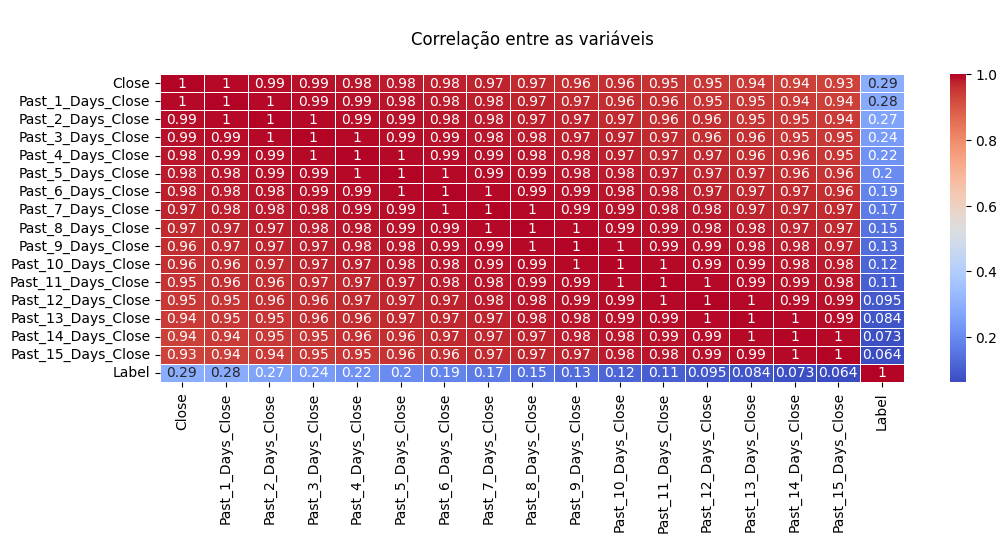

In [13]:
correlation = spec_bbas3_test.select_dtypes("number").corr()

plt.figure(figsize=(12, 4))

sns.heatmap(
    correlation, 
    annot=True, 
    annot_kws={"size" : 10},
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5,
    linecolor="white"
)

plt.title("\nCorrelação entre as variáveis\n", fontdict={"size" : 12})

plt.show()

Além disso, note que as mesmas observações realizadas na matriz de correlação das variáveis do conjunto de treino também estão presentes no conjunto de teste, ou seja, mesmo que baixa, há uma correlação entre a variável alvo e o valor do fechamento das ações nos últimos 15 dias.

#### Modelagem e avaliação dos resultados

In [14]:
print(f"Valores possíveis da variável alvo nos conjuntos de:\n -> Treino: {list(spec_bbas3_train['Label'].unique())}\n -> Teste: {list(spec_bbas3_test['Label'].unique())}")

Valores possíveis da variável alvo nos conjuntos de:
 -> Treino: [-1, 1]
 -> Teste: [-1, 1]


Como apresentado anteriormente, a variável alvo pode assumir os valores do intervalo [-1, 1], o que pode ser um problema ao utilizarmos a função de ativação sigmoid (que assume valores no intervalo [0, 1]), sendo assim, substituímos os valores -1 por 0.

In [15]:
spec_bbas3_train["Label"] = spec_bbas3_train["Label"].apply(lambda x: 0 if x == -1 else 1)
spec_bbas3_test["Label"] = spec_bbas3_test["Label"].apply(lambda x: 0 if x == -1 else 1)
print(f"Valores possíveis da variável alvo nos conjuntos de:\n -> Treino: {list(spec_bbas3_train['Label'].unique())}\n -> Teste: {list(spec_bbas3_test['Label'].unique())}")

Valores possíveis da variável alvo nos conjuntos de:
 -> Treino: [0, 1]
 -> Teste: [0, 1]


Feito isso, iremos realizar quatro testes para o baseline: sem normalizações, com standard scalling, com minmax scalling e com robust scalling. Para isso serão construídas as variáveis "x", "x_standard", "x_minmax" e "x_robust".

In [16]:
x_train = np.array(spec_bbas3_train.drop(columns=["Label"]))
x_test = np.array(spec_bbas3_test.drop(columns=["Label"]))

x_standard_train = np.array(StandardScaler().fit_transform(spec_bbas3_train.drop(columns=["Label"])))
x_standard_test = np.array(StandardScaler().fit_transform(spec_bbas3_test.drop(columns=["Label"])))

x_minmax_train = np.array(MinMaxScaler().fit_transform(spec_bbas3_train.drop(columns=["Label"])))
x_minmax_test = np.array(MinMaxScaler().fit_transform(spec_bbas3_test.drop(columns=["Label"])))

x_robust_train = np.array(RobustScaler().fit_transform(spec_bbas3_train.drop(columns=["Label"])))
x_robust_test = np.array(RobustScaler().fit_transform(spec_bbas3_test.drop(columns=["Label"])))

x_list_train = [["Não", x_train], ["Standard", x_standard_train], ["Minmax", x_minmax_train], ["Robust", x_robust_train]]
x_list_test = [["Não", x_test], ["Standard", x_standard_test], ["Minmax", x_minmax_test], ["Robust", x_robust_test]]

y_train = np.array(spec_bbas3_train["Label"])
y_test = np.array(spec_bbas3_test["Label"])

Com as variáveis independentes tratadas, podemos iniciar o desenho da topologia da rede neural. 

Optamos por seguir com o uso das LSTM (Long Short-Term Memory), visto a sua capacidade de "lembrar" de dados já processados em um determinado espaço de tempo, o que as tornam fortes candidatas para solucionar o problema que queremos resolver: comprar ou vender uma determinada ação.

Sendo assim, iremos realizar testes utilizando as camadas LSTM, Dropout e Densa variando o número de camadas (1, 2 e 3) e neurônios (16, 32 e 64) para cada conjunto X (não normalizado, standard, minmax e robust) de variáveis.

- Teste 1

    - 1 Camada LSTM (sem retorno) com 16 unidades 
    - 1 Camada Dropout (0.1 * número da camada) 
    - 1 Camada Densa (sigmoid) com 1 unidade

- Teste 2 
    - 1 Camada LSTM (com retorno) com 16 unidades
    - 1 Camada Dropout (0.1 * número da camada)
    - 1 Camada LSTM (sem retorno) com 16 unidades 
    - 1 Camada Dropout (0.1 * número da camada) 
    - 1 Camada Densa (sigmoid) com 1 unidade

- Teste 3
    - 1 Camada LSTM (com retorno) com 16 unidades
    - 1 Camada Dropout (0.1 * número da camada)
    - 1 Camada LSTM (com retorno) com 16 unidades
    - 1 Camada Dropout (0.1 * número da camada)
    - 1 Camada LSTM (sem retorno) com 16 unidades 
    - 1 Camada Dropout (0.1 * número da camada) 
    - 1 Camada Densa (sigmoid) com 1 unidade

In [17]:
grid = [[1,16], [1,32], [1,64], [2,16], [2,32], [2,64], [3,16], [3,32], [3,64]]
grid_size = len(grid)

In [18]:
# Inicializa variáveis auxiliares
network_index = 0

# Instancia o modelo
lstm = CL()

# Percorre o grid de treinos
for i in range(grid_size):
    # Percorre a lista de normalizações de treino
    for x_i_train, x_i_test in zip(x_list_train, x_list_test):
        # Apresenta a topologia da i-ésima rede neural
        print(f"\nTopologia: {network_index}\n -> {grid[i][0]}x LSTM com {grid[i][1]} neurônios\n -> 1x Dropout com rate de {round(0.1 * grid[i][0], 2)}\n -> 1x Densa\n -> Normalização: {x_i_train[0]}")
        # Constrói, compila e treina a topologia da i-ésima rede neural
        lstm.build_model(c_layers_number=grid[i][0], c_units_number=grid[i][1], c_dropout_rate=0.1, c_input_shape=(16, 1))
        lstm.compile_model(c_optimizer="adam", c_loss="binary_crossentropy", c_metrics=["accuracy"])
        lstm.fit_model(c_x=x_i_train[1], c_y=y_train, c_test_size=0.3, c_random_state=42, c_epochs_number=100, c_batches_number=64, c_verbose=0)
        lstm.evaluate_model()
        lstm.predict_model(c_x=x_i_test[1])
        network_index += 1


Topologia: 0
 -> 1x LSTM com 16 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: Não
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8229 - loss: 0.3934
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Topologia: 1
 -> 1x LSTM com 16 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: Standard
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8319 - loss: 0.3586
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Topologia: 2
 -> 1x LSTM com 16 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: Minmax
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7336 - loss: 0.5235
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Topologia: 3
 -> 1x LSTM com 16 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: Robust
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7993 - loss: 0.3809
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Topologia: 4
 -> 1x LSTM com 32 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: 

In [19]:
# Inicializa variáveis auxiliares
champion_index = 0
current_loss = float("+inf")
current_accuracy = float("-inf")

# Realiza a atualização para apresentar a arquitetura mais performática
for i in range(len(lstm.c_model_scores_train)):
    if lstm.c_model_scores_train[i][0] < current_loss:
        current_loss = round(lstm.c_model_scores_train[i][0], 2)
        champion_index = i
    if lstm.c_model_scores_train[i][1] > current_accuracy:
        current_accuracy = round(lstm.c_model_scores_train[i][1], 2)
        champion_index = i

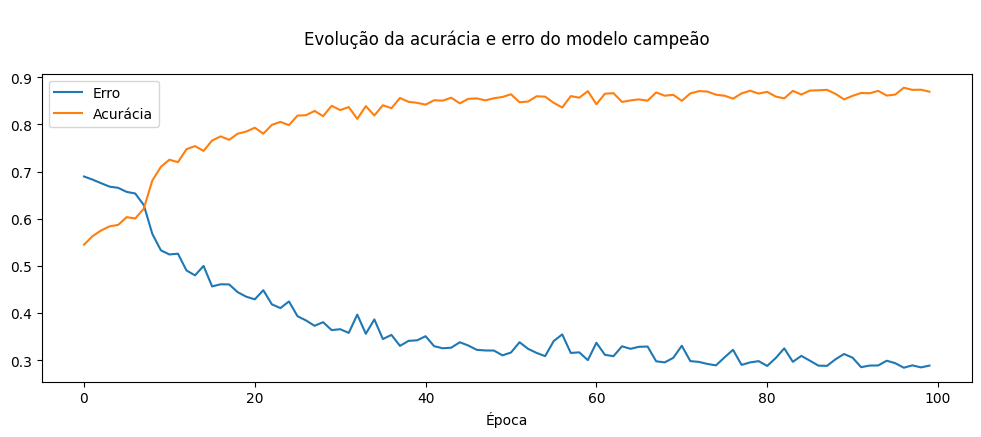

In [20]:
plt.figure(figsize=(12, 4))
plt.plot(lstm.c_model_statistics_train[champion_index][1])
plt.plot(lstm.c_model_statistics_train[champion_index][0])
plt.title("\nEvolução da acurácia e erro do modelo campeão\n")
plt.xlabel("Época")
plt.legend(["Erro", "Acurácia"], loc="upper left")
plt.show()

In [21]:
y_pred = (lstm.c_predicts[champion_index] > 0.5).astype(int)
confu_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"\nInformações do modelo campeão:\n\n -> Topologia: {champion_index}\n\n -> Acurácia: {current_accuracy}%\n\n -> Erro: {current_loss}%\n\n -> Matriz de confusão\n{confu_matrix}\n\n -> Reporte de classificação\n{class_report}")


Informações do modelo campeão:

 -> Topologia: 20

 -> Acurácia: 0.87%

 -> Erro: 0.29%

 -> Matriz de confusão
[[163 526]
 [  4 492]]

 -> Reporte de classificação
              precision    recall  f1-score   support

           0       0.98      0.24      0.38       689
           1       0.48      0.99      0.65       496

    accuracy                           0.55      1185
   macro avg       0.73      0.61      0.52      1185
weighted avg       0.77      0.55      0.49      1185



Como apresentado acima, a 20° topologia (2x LSTM com 64 neurônios + 2x Dropout com rate de 0.2 + 1x Densa + Normalização: Não) apresentou a maior acurácia dentre as demais topologias, entretanto, apegar-se apenas a essa métrica é um erro, visto que como apresentado na matriz de confusão, grande parte das predições que deveriam ser vendas foram classificadas como compras, ou seja, estaríamos perdendo dinheiro ao comprar as ações com um alto valor.

Como hipótese inicial, entendemos que a baixa precisão para venda de ações foi ocasionada pelo desbalanceamento de classes, visto que no conjunto de treinamento a representividade foi de ~55%, enquanto que no conjunto de teste a representativa foi de apenas 42%. Para validar esse ponto, iremos balancear os conjuntos de dados e realizar um novo treinamento com a topologia campeã.